### Build a PDF ingestion and Question/Answering system

PDF files often hold crucial unstructured data unavailable from other sources. They can be quite lengthy, and unlike plain text files, cannot generally be fed directly into the prompt of a language model.

In this tutorial, you'll create a system that can answer questions about PDF files. More specifically, you'll use a Document Loader to load text in a format usable by an LLM, then build a retrieval-augmented generation (RAG) pipeline to answer questions, including citations from the source material.

This tutorial will gloss over some concepts more deeply covered in our RAG tutorial, so you may want to go through those first if you haven't already.

In [1]:
from langchain_community.document_loaders import PyPDFDirectoryLoader #see https://python.langchain.com/v0.2/docs/how_to/document_loader_pdf/#pypdf-directory

file_path = "./PDF" #folder where we store the pdf files
loader=PyPDFDirectoryLoader(file_path)
docs=loader.load() #return a list of documents 

In [2]:
display(f'Cantidad de documentos creados:{len(docs)}')
display(docs[10])


'Cantidad de documentos creados:79'

Document(page_content=' 11El Ser es la única Vida, eterna, siempre presente, más allá de las miles de formas de la vida que están \nsujetas al nacimiento y a la muerte. Sin embargo, el Ser no sólo está más all á, sino también profundamente \ndentro de cada forma como su esencia más ínti mamente invisible e indestructible. Esto significa que es \naccesible a usted ahora como su propio ser más profundo, su verdadera naturaleza. Pero no busque \ncaptarlo con la mente. No  trate de entenderlo. Usted puede conocerlo sólo cuando la mente está in móvil. \nCuando usted está presente, cuando su atención está com pleta e intensamente en el Ahora, se puede sentir \nel Ser, pero nunca puede ser entendido mentalmente. Recuperar la conci encia del Ser y permanecer en ese \nestado de "sentimiento -realización" es la iluminación.  \n \n\x1f\x1f  \nCuando usted dice Ser ¿está hablando de Dios? Si es así ¿por qué no lo dice?  \n \nLa palabra Dios se ha vuelto vacía de significado a través de miles de añ

In [3]:
display(docs[10].page_content)
display(docs[10].metadata)


' 11El Ser es la única Vida, eterna, siempre presente, más allá de las miles de formas de la vida que están \nsujetas al nacimiento y a la muerte. Sin embargo, el Ser no sólo está más all á, sino también profundamente \ndentro de cada forma como su esencia más ínti mamente invisible e indestructible. Esto significa que es \naccesible a usted ahora como su propio ser más profundo, su verdadera naturaleza. Pero no busque \ncaptarlo con la mente. No  trate de entenderlo. Usted puede conocerlo sólo cuando la mente está in móvil. \nCuando usted está presente, cuando su atención está com pleta e intensamente en el Ahora, se puede sentir \nel Ser, pero nunca puede ser entendido mentalmente. Recuperar la conci encia del Ser y permanecer en ese \nestado de "sentimiento -realización" es la iluminación.  \n \n\x1f\x1f  \nCuando usted dice Ser ¿está hablando de Dios? Si es así ¿por qué no lo dice?  \n \nLa palabra Dios se ha vuelto vacía de significado a través de miles de años de mal uso. Yo la u

{'source': 'PDF\\Tolle_Eckhart-El_Poder_del_Ahora.pdf', 'page': 10}

So what just happened?

- The loader reads the PDF at the specified path into memory.
- It then extracts text data using the pypdf package.
- Finally, it creates a LangChain Document for each page of the PDF with the page's content and some metadata about where in the document the text came from.

LangChain has many [other document loaders](https://python.langchain.com/v0.2/docs/integrations/document_loaders/) for other data sources, or you can create a custom document loader.

## Question answering with RAG

Next, you'll prepare the loaded documents for later retrieval. Using a text splitter, you'll split your loaded documents into smaller documents that can more easily fit into an LLM's context window, then load them into a vector store. You can then create a retriever from the vector store for use in our RAG chain:

In [4]:
from langchain_chroma import Chroma #to store embeddings
from langchain_openai import OpenAIEmbeddings #to convert text to vectors of numbers with semantic meaning
from langchain_text_splitters import RecursiveCharacterTextSplitter #to split documents
from langchain_core.output_parsers import StrOutputParser #to format the output
from langchain_core.runnables import RunnablePassthrough  #identity funcion
from langchain_core.prompts import ChatPromptTemplate #we could have installed langchain hub and import some useful prompt
from langchain_openai import ChatOpenAI #we'll use gpt
import os

In [6]:
persist_directory="./db"  #only if we want to store the vectorstore on disk
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
#we use text-embedding-3-small because is faster and cheaper than the default model text-embedding-ada-002
if os.path.exists(persist_directory):
    vectorstore = Chroma(collection_name="pdf_vector_store",persist_directory=persist_directory,
                         embedding_function=OpenAIEmbeddings(model="text-embedding-3-small"))
    
else:    
    vectorstore = Chroma.from_documents(collection_name="pdf_vector_store",documents=splits,
                                    embedding=OpenAIEmbeddings(model="text-embedding-3-small"),
                                    persist_directory=persist_directory)
retriever=vectorstore.as_retriever()

In [16]:
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise. Always answer in the same language as the query"
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{question}"),
    ]
)

#we join each document content
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


In [13]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

In [17]:
rag_chain = (
    {"context":retriever | format_docs , "question":RunnablePassthrough() }
   | prompt |  llm | StrOutputParser()
)

In [18]:
rag_chain.invoke("Como puedo estar enfocado en el ahora?")

'Puedes estar enfocado en el ahora practicando la conciencia del momento presente, sintiendo tu cuerpo interior mientras realizas tus actividades diarias. Observa la tendencia de tu mente a escapar del presente y dirige tu atención hacia el ahora para crear una brecha de no-mente. Esto te permitirá estar alerta y consciente sin pensar, lo cual es esencial para la meditación y para permanecer en el presente.'

If we want to know which documents are involved in the final output we can do that as follow:

In [20]:
#Starting with a dict with the input question, add the retrieved docs in the "context" key
rag_chain_from_docs=(
    RunnablePassthrough.assign(context=(lambda x:format_docs(x["context"]))) #Assigns new fields to the dict output of this runnable. Returns a new runnable.
    | prompt
    | llm
    | StrOutputParser()
)

retrieve_docs = (lambda x: x["question"]) | retriever
#Feed both the query and context into a RAG chain and add the result to the dict ("answer" key)
chain = RunnablePassthrough.assign(context=retrieve_docs).assign(answer=rag_chain_from_docs) #Assigns new fields to the dict output of this runnable. Returns a new runnable.

In [41]:
result=chain.invoke({"question":"Como puedo estar enfocado en el ahora?"})

In [42]:
result

{'question': 'Como puedo estar enfocado en el ahora?',
 'context': [Document(page_content='siempre está ligado con enfocarse en el fut uro y no estar en contacto con el Ahora. Puesto que en el Ahora no \nhay problemas, tampoco hay miedo. Si surgiera una situación que usted debe solucionar ahora, su acción será \nclara e incisiva si surge de la conciencia del momento presente. También es más p robable que sea efectiva. \nNo será una reacción que surge del condicionamiento pasado de su mente sino una respuesta intuitiva a la \nsituación. En otros casos, si la mente ligada al tiempo hubiera reaccionado, usted encontraría más efec tivo no \nhacer nada, s implemente permanecer concentrado en el Ahora.  \n \nUN SALTO CUÁNTICO EN LA EVOLUCIÓN DE LA CONCIENCIA  \n \nHe tenido atisbos de este estado de libertad de la mente y del tiempo que usted describe, pero el \npasado y el futuro son tan abrumadoramente fuertes que no puedo mantenerlos fuera por mucho \ntiempo.  \n \nEl modo de la concienci

In [39]:
display(f"# of docs: {len(result["context"])}")
display(result["answer"])
display(result["context"])
display([m.metadata for m in result["context"]])

'# of docs: 4'

'"Los Hornos de Hitler" describe el papel de los nazis en la persecución y eliminación de grupos religiosos y minorías durante la Segunda Guerra Mundial, incluyendo a cristianos y católicos. Se relata cómo Hitler implementó métodos como la eutanasia para deshacerse de personas consideradas no aptas o no deseadas por el régimen nazi. Además, se detalla la colaboración de ciertas secciones del gobierno alemán en la persecución de grupos religiosos, como el Departamento de Iglesias Cristianas.'

[Document(page_content='Los hoRnos De hitLeR\n15horrible dios tuerto pagano de los alemanes, era muy celoso y no \ntoleraba la competencia de un Dios cristiano. ¡Las monjas, los \nsacerdotes y los líderes cristianos tenían que desaparecer! Eran \nacusados de sabotaje, actividades antigermanas, etcétera, y la \nGestapo los llamaba a declarar. Una vez en manos de la Gestapo, nunca se les daba la oportunidad de probar su inocencia.\nNo solamente las monjas eran llevadas al cautiverio —nos \ncontaba el mayor — sino que también sus protegidos, los niños que cuidaban en orfanatorios y escuelas eran tomados su -\nbrepticiamente durante la noche por los alemanes para evitar ser vistos. Los prisioneros eran enviados a los innumerables \ncampos de concentración diseminados en Europa ocupada, o \nsimplemente enviados directamente a la muerte.\nNos decía que los alemanes nunca usaban las palabras ase -\nsinato o muerte por gas. Simplemente se concretaban a escribir \nal lado de los nombres de sus 

[{'page': 7, 'source': 'PDF\\43812_1_T_HORNOS_HITLER.pdf'},
 {'page': 2, 'source': 'PDF\\43812_1_T_HORNOS_HITLER.pdf'},
 {'page': 8, 'source': 'PDF\\43812_1_T_HORNOS_HITLER.pdf'},
 {'page': 6, 'source': 'PDF\\43812_1_T_HORNOS_HITLER.pdf'}]

We can see the trace in Langsmith

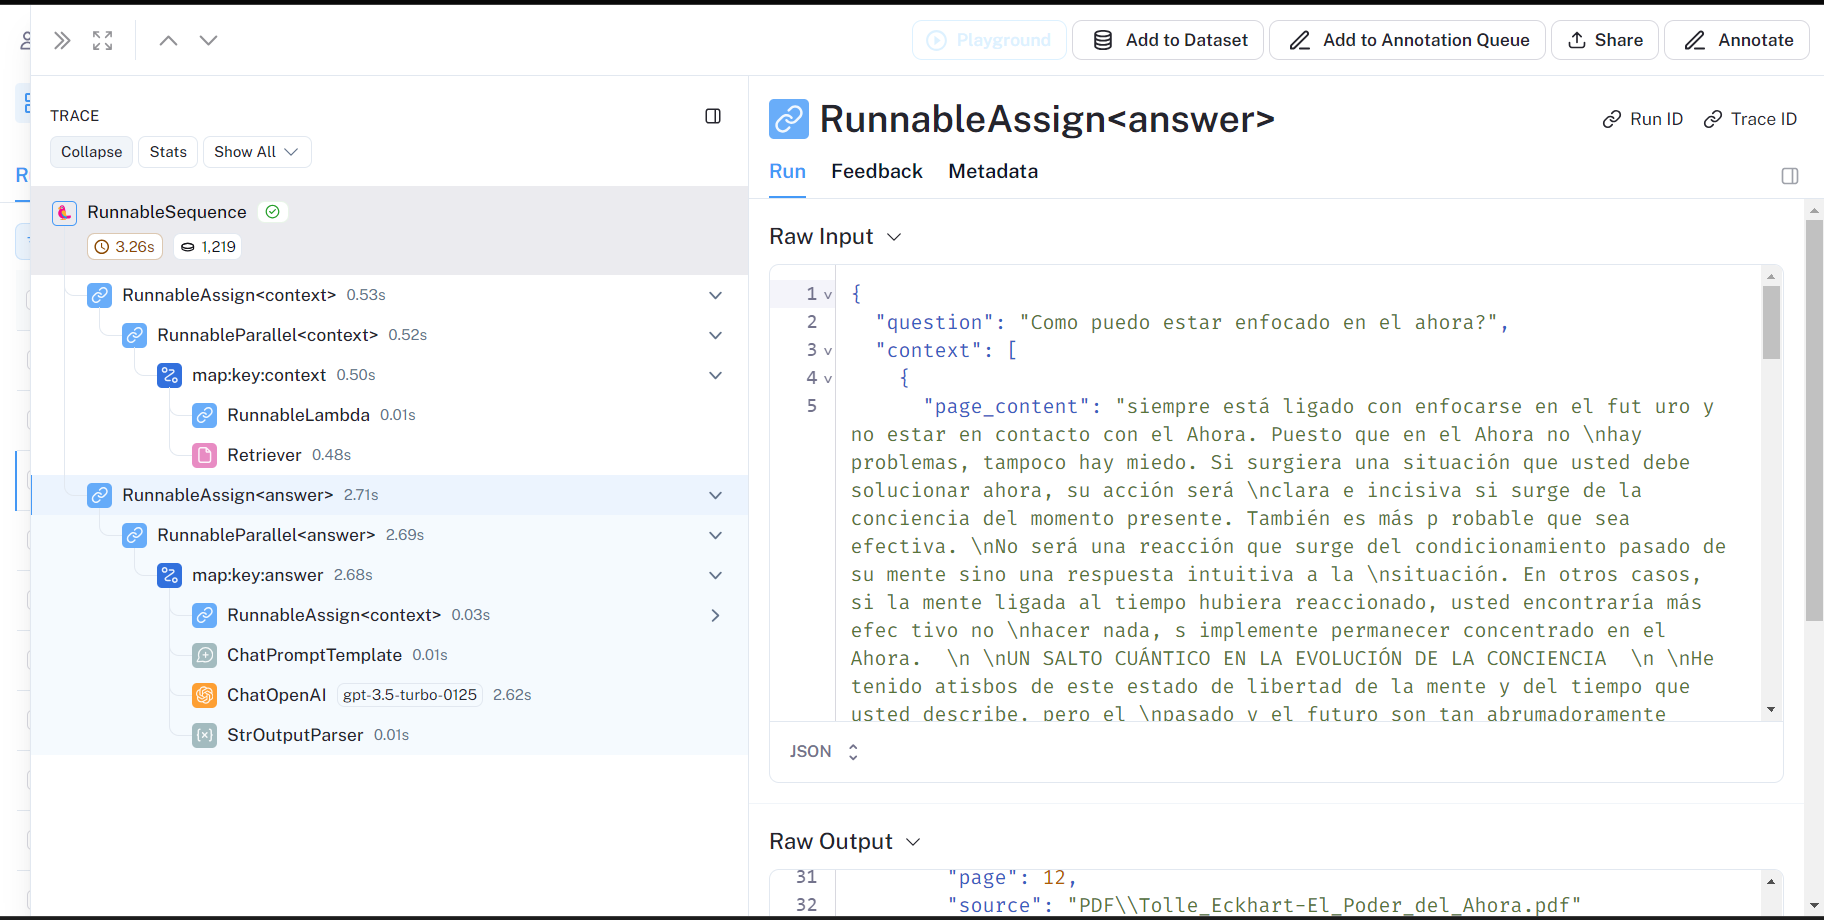

In [7]:
# cleanup
# vectorstore.delete_collection()